# check how many utility boxes were detected in current segmentation model

In [1]:
import numpy as np
import os
import pandas as pd
import glob


ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
META_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv"

EXFOLDER = os.path.join(CURATED_FOLDER, "c_seg_crossectional_all")
if not os.path.exists(EXFOLDER):
    os.makedirs(EXFOLDER)
    
EXFOLDER_LONG = os.path.join(CURATED_FOLDER, "c_seg_longitudinal_all")
if not os.path.exists(EXFOLDER_LONG):
    os.makedirs(EXFOLDER_LONG)
    
TOTAL_PX = 160000
H3_RES = [8, 9, 12]
box_id = [41, 50, 79] # these are from the object150 dataset (box, refrigerator, hut)

In [11]:
def get_result(cityabbr, curated_folder, f_suffixes = "*panoptic.csv"):
    outfolder = f"{curated_folder}/{cityabbr}"
    seg_file = glob.glob(os.path.join(outfolder, f_suffixes))
    panoptic_df = []
    for p in seg_file:
        temp = pd.read_csv(p)
        panoptic_df.append(temp)
    panoptic_df = pd.concat(panoptic_df).reset_index(drop = True)
    return panoptic_df

In [2]:

PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
GSV_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
FOLDER_TO_SAVE = "{ROOTFOLDER}/_transformed/utility_box_v{version}/{cityabbr}"
FILE_TO_SAVE = (
    "{ROOTFOLDER}/_transformed/utility_box_v{version}/{cityabbr}/n={part}_objects.parquet"
)
YEAR_SEL = [2022, 2021, 2020]
def get_path_with_sidewalk(cityabbr):
    seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
    seg_df_sel = seg_df[(seg_df['labels']==11)&(seg_df['areas']>=10)].reset_index(drop = True)[["img"]]
    gsv_path_df = pd.read_csv(GSV_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr))
    pano_df = pd.read_csv(PANO_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr))
    pano_sel = pano_df[pano_df['year'].isin(YEAR_SEL)].reset_index(drop = True)
    seg_df_sel['panoid'] = seg_df_sel['img'].apply(lambda x: x[:22])
    pano_sel = pano_sel[pano_sel['panoid'].isin(seg_df_sel['panoid'].values)].reset_index(drop = True)
    gsv_path_df['panoid'] = gsv_path_df['path'].apply(lambda x: x.split("/")[-1][:22])
    sel_path = gsv_path_df.merge(pano_sel, on="panoid")
    
    return sel_path[['path']]

In [ ]:
city = "New York"
cityabbr = city.lower().replace(" ", "")
sel_path = get_path_with_sidewalk(cityabbr)
seg_sel_top = seg_df[seg_df['labels'] ==11].nlargest(40, 'areas')
# print(seg_sel_top['img'].unique())
meta_sel = meta_df[meta_df["img"].isin(seg_sel_top["img"].values)].reset_index()

NameError: name 'YEAR_SEL' is not defined

# Check the YOLO new results (2025-08-16)

In [5]:
VERSION = 2
city = "Detroit"
cityabbr = city.lower().replace(" ", "")
FOLDER_TO_SAVE = "{ROOTFOLDER}/_transformed/utility_box_v{version}/{cityabbr}"
folder_to_save = FOLDER_TO_SAVE.format(version = VERSION, ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr)
files_saved = os.listdir(folder_to_save)
df_infered = pd.read_parquet(os.path.join(folder_to_save, files_saved[0]))
df_infered

object_name  confidence          x1          y1          x2          y2  \
0    utility_box    0.818257    0.142130  241.990875   42.463097  295.949219   
1    utility_box    0.872648  134.365967  198.519592  167.462341  248.303406   
2    utility_box    0.883795  183.785980  197.149658  202.461838  215.605026   
3    utility_box    0.799951  158.403748  196.697617  177.738266  217.258606   
4    utility_box    0.605910  208.483093  196.870880  227.176849  215.994690   
..           ...         ...         ...         ...         ...         ...   
788  utility_box    0.337525   14.729023  297.754517  396.980286  398.248413   
789  utility_box    0.337525   14.729023  297.754517  396.980286  398.248413   
790  utility_box    0.337525   14.729023  297.754517  396.980286  398.248413   
791  utility_box    0.769548  338.387024  149.166138  399.789093  260.446198   
792  utility_box    0.917877    0.000000  153.267029   84.482819  253.360718   

                                img  
0     BqP1zWlro3H4o4_t0QhgHA_90.jpg  
1    tah6Acoa6yBZ7HJPMbTgJw_180.jpg  
2      vMcV9BPgZ0qd3GGeSvIdrg_0.jpg  
3      vMcV9BPgZ0qd3GGeSvIdrg_0.jpg  
4      vMcV9BPgZ0qd3GGeSvIdrg_0.jpg  
..                              ...  
788  hXq8RYfWqFCVDhw1hq5ixw_270.jpg  
789  hXq8RYfWqFCVDhw1hq5ixw_270.jpg  
790  hXq8RYfWqFCVDhw1hq5ixw_270.jpg  
791   3QZSYQEPrscDk5z8u5eC9w_90.jpg  
792  3QZSYQEPrscDk5z8u5eC9w_180.jpg  

[793 rows x 7 columns]

In [14]:
imgls = df_infered[df_infered['confidence']>=0.9]['img'].unique()
gsv_path_df = pd.read_csv(GSV_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr))
gsv_path_df['img'] = gsv_path_df['path'].apply(lambda x: x.split("/")[-1])
gsv_path_sel = gsv_path_df[gsv_path_df['img'].isin(imgls)].reset_index(drop = True)
gsv_path_sel.head()

path                  panoid  \
0  /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...  Xwp0pHjj_z845ccdA3auxA   
1  /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...  JdqBWS0o5dm-vqzJkOv6tQ   
2  /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...  9qRjGFc5OTxObQ7HZw0txA   
3  /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...  6PvXqC7sfkIdCH5XIelrnA   
4  /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_r...  fqXDqU5ZEPgXGBH89GkZkQ   

    size                             img  
0  34267  Xwp0pHjj_z845ccdA3auxA_180.jpg  
1  32349  JdqBWS0o5dm-vqzJkOv6tQ_180.jpg  
2  34657    9qRjGFc5OTxObQ7HZw0txA_0.jpg  
3  24022   6PvXqC7sfkIdCH5XIelrnA_90.jpg  
4  34500    fqXDqU5ZEPgXGBH89GkZkQ_0.jpg

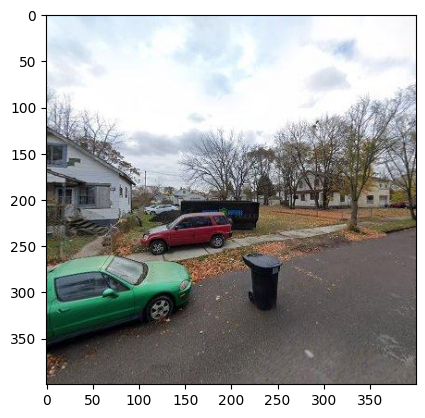

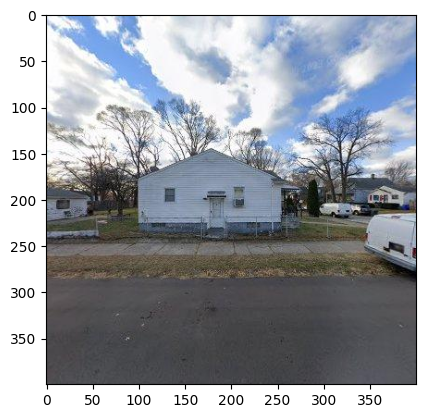

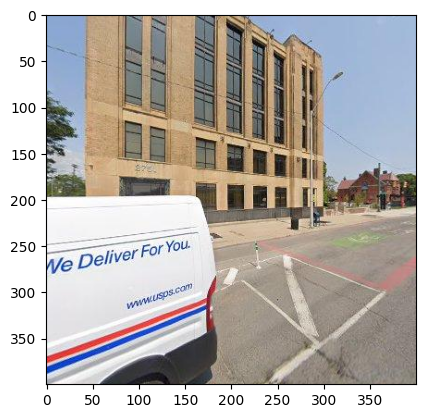

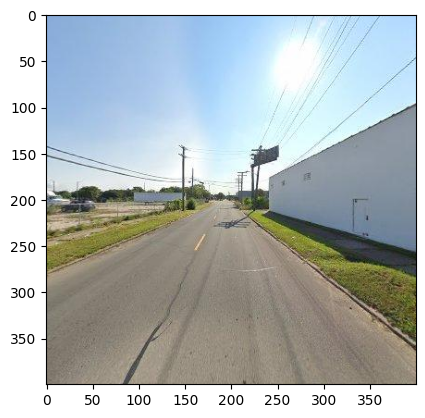

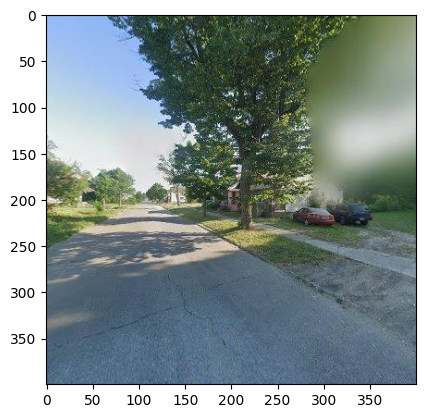

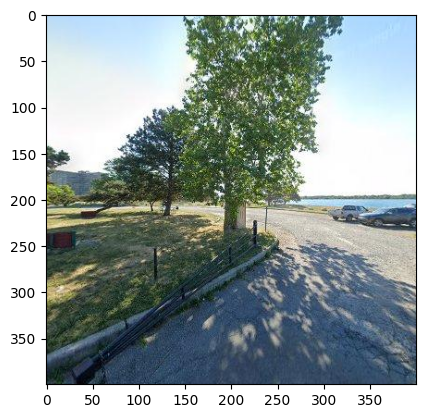

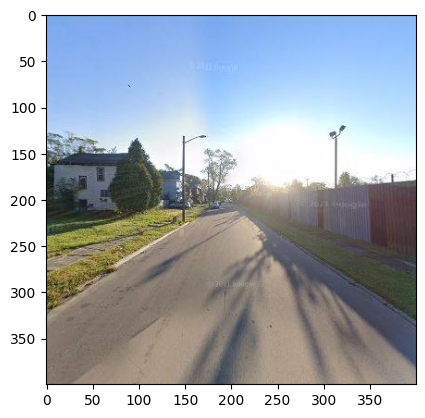

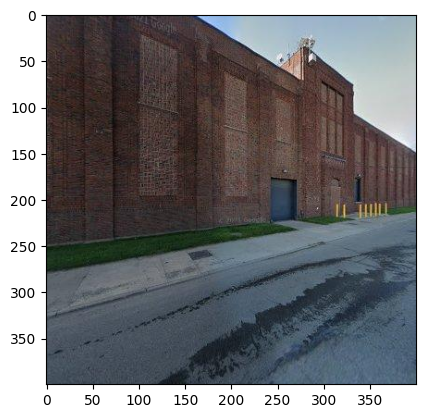

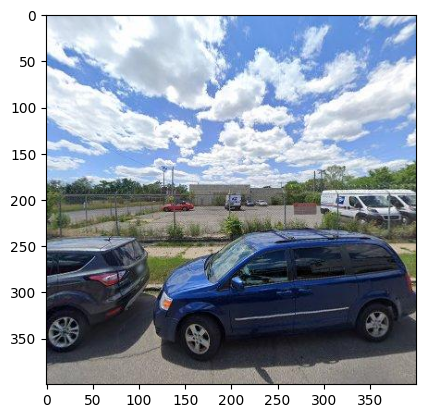

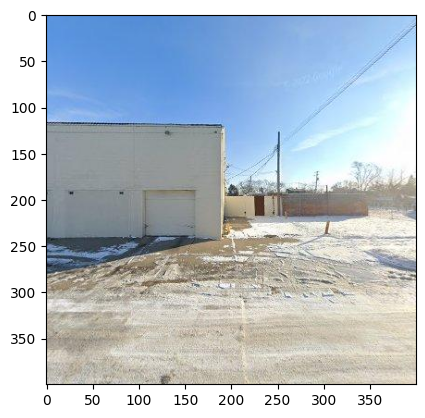

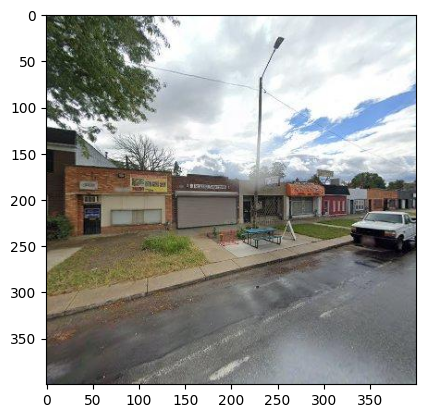

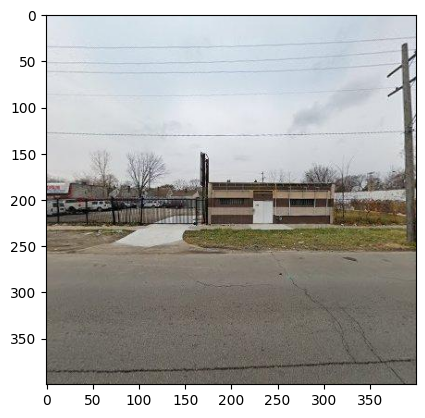

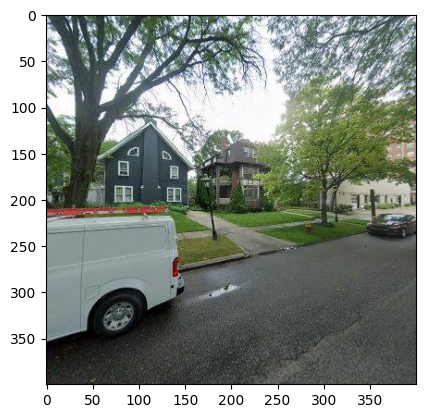

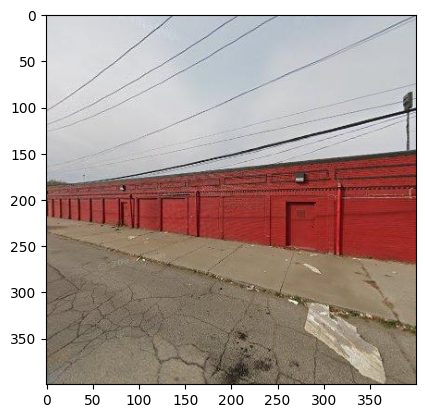

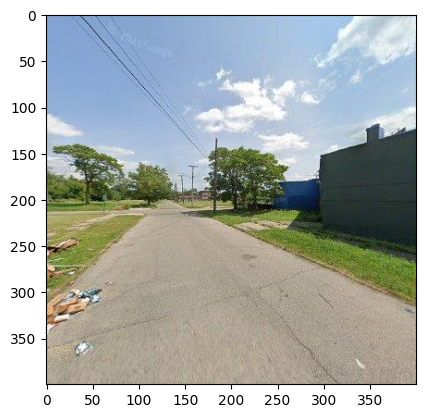

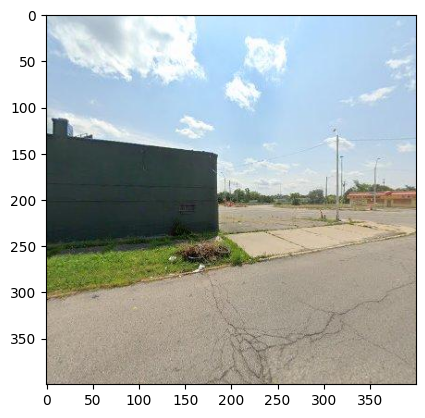

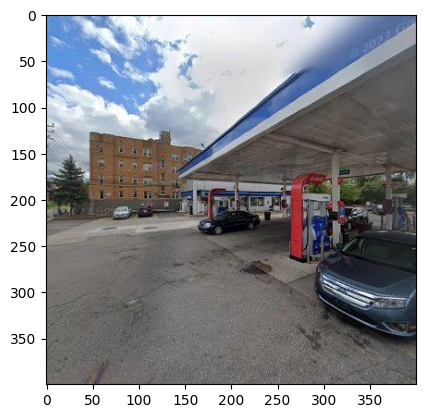

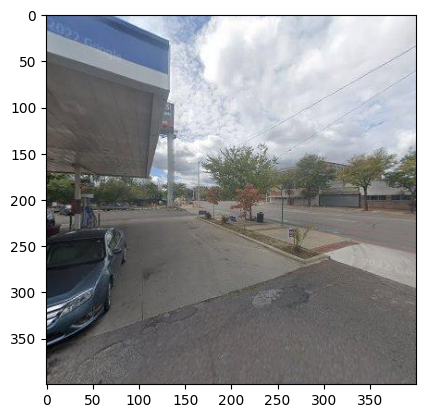

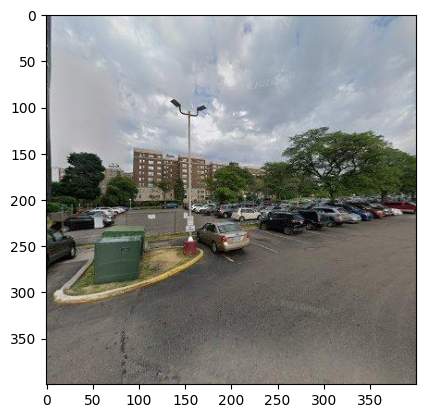

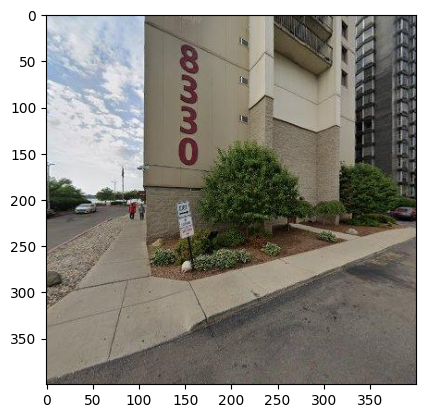

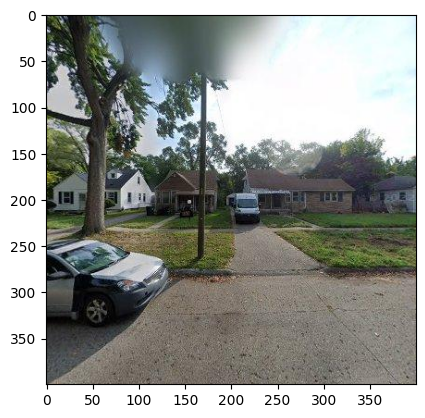

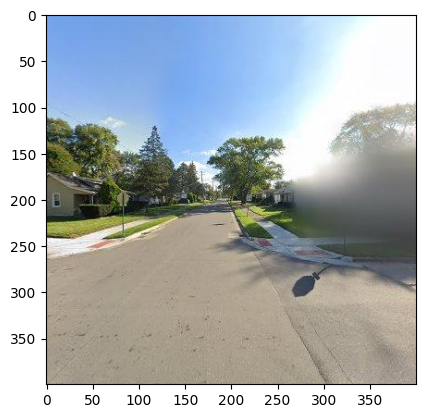

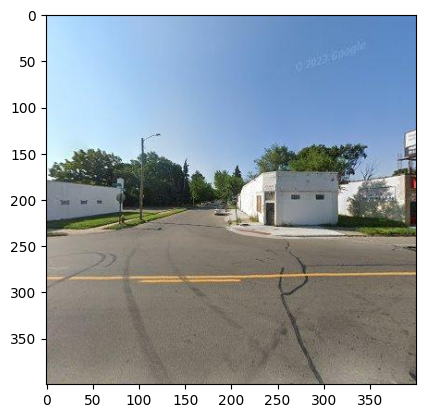

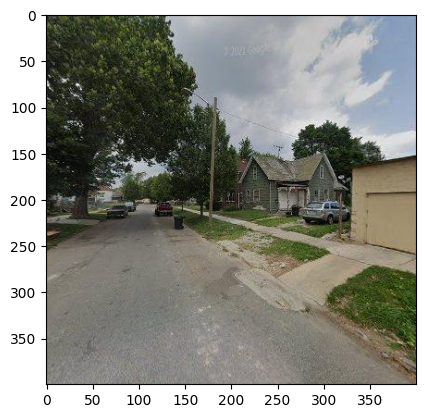

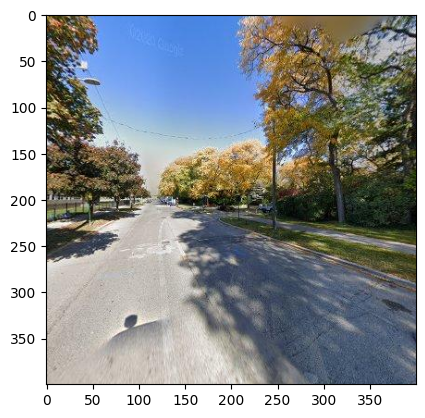

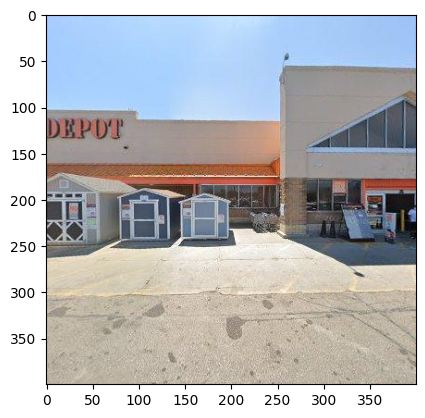

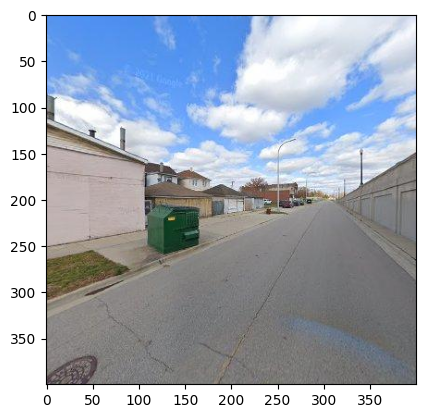

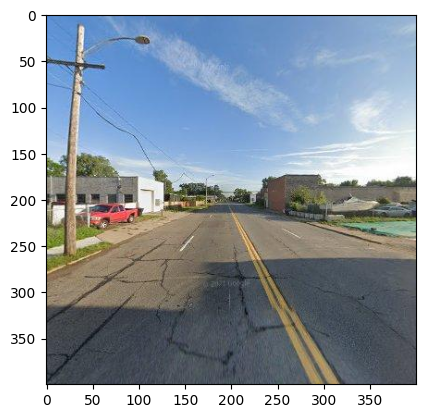

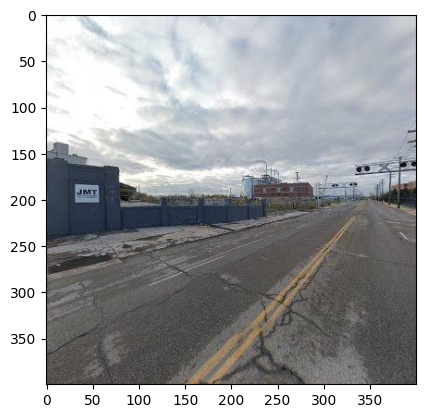

In [15]:
import cv2
import matplotlib.pyplot as plt

for path_plot in gsv_path_sel['path'].values[:30]:

    img = cv2.imread(path_plot)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="qbNRMgn9jHdqZxatrsLl")
# project = rf.workspace("utility-box").project("utility_box-m5cgh")
# version = project.version(2)
# dataset = version.download("yolov11")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to utility_box-2 in yolov11:: 100%|██████████| 907/907 [00:03<00:00, 239.72it/s]


In [5]:
from ultralytics import YOLOv10
model = YOLOv10("/scr/u/yuanzf/yolov10/releases/download/v1.1/yolov10x.pt")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/scr/u/yuanzf/anaconda3/envs/yolov10/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/scr/u/yuanzf/anaconda3/envs/yolov10/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/scr/u/yuanzf/anaconda3/envs/yolov10/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/scr/u/yuanzf/anaconda3/envs/yolov10/lib/python3.9/site-packages/traitlets/config/application.py", lin

In [1]:
!yolo task=detect mode=train epochs=500 batch=32 plots=True \
model=/scr/u/yuanzf/yolov10/releases/download/v1.1/yolov10s.pt \
data=/home/yuanzf/uvi-time-machine/_script/B-timemachine/utility_box-2/data.yaml

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.93 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (Quadro RTX 6000, 24024MiB)
engine/trainer: task=detect, mode=train, model=/scr/u/yuanzf/yolov10/releases/download/v1.1/yolov10s.pt, data=/home/yuanzf/uvi-time-machine/_script/B-timemachine/utility_box-2/data.yaml, epochs=500, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, au

In [ ]:
# test inference
model_path = "/home/yuanzf/uvi-time-machine/_script/B-timemachine/runs/detect/train/weights/best.pt"